In [90]:
# Chargement des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import shap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno
import warnings
import model_functions
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [91]:
# Chargement des données
df=model_functions.read_data('data.csv')
df

Aperçu des données (7431 lignes, 27 colonnes):
Conversion de 'listing_price': float64 -> float64, valeurs NA créées: 244
Conversion de 'price_ttc': float64 -> float64, valeurs NA créées: 244
Conversion de 'price': float64 -> float64, valeurs NA créées: 244
Conversion de 'size': int64 -> int64, valeurs NA créées: 0
Conversion de 'rooms': float64 -> float64, valeurs NA créées: 14
Conversion de 'bedrooms': float64 -> float64, valeurs NA créées: 14
Conversion de 'bathrooms': float64 -> float64, valeurs NA créées: 14
Conversion de 'parkings': float64 -> float64, valeurs NA créées: 11
Conversion de 'construction_year': float64 -> float64, valeurs NA créées: 4968
Conversion de 'age': float64 -> float64, valeurs NA créées: 4969
Conversion de 'air_conditioning': float64 -> float64, valeurs NA créées: 1863
Conversion de 'central_heating': float64 -> float64, valeurs NA créées: 1863
Conversion de 'swimming_pool': float64 -> float64, valeurs NA créées: 1863
Conversion de 'elevator': float64 -> flo

,source,neighborhood,city,state,transaction,property_type,date,listing_price,suffix,price_ttc,price,size,rooms,bedrooms,bathrooms,parkings,finishing,condition,construction_year,age,air_conditioning,central_heating,swimming_pool,elevator,garden,equipped_kitchen,amenities
0,century 21,Ain Zaghouan Nord,Ain Zaghouan,Tunis,sale,villa,2/12/2025,1700000.0,TTC,1700000.0,1700000.0,400,7.0,5.0,4.0,1.0,haut standing,bonne condition,2012.0,13.0,1.0,1.0,0.0,0.0,1.0,1.0,Parking+Terrasse+Chauffage Central+Prise lave-...
1,century 21,Ain Zaghouan Nord,Ain Zaghouan,Tunis,sale,villa,8/24/2024,1580000.0,TTC,1580000.0,1659000.0,600,7.0,5.0,3.0,3.0,moyen standing,excellente condition,NaN,NaN,1.0,1.0,1.0,0.0,1.0,1.0,Terrasse+Chambre de Service+Parking+Chauffage ...
2,tecnocasa,Ain Zaghouan,Ain Zaghouan,Tunis,sale,villa,4/11/2025,1500000.0,TTC,1500000.0,1500000.0,368,0.0,0.0,0.0,0.0,moyen standing,bonne condition,2008.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,century 21,Ain Zaghouan Nord,Ain Zaghouan,Tunis,sale,appartement,11/17/2023,1200000.0,TTC,1200000.0,1323000.0,256,6.0,4.0,3.0,1.0,haut standing,neuf,2023.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,Piscine+Prise lave-vaisselle+Chauffage Central...
4,century 21,Ain Zaghouan Nord,Ain Zaghouan,Tunis,sale,duplex,11/16/2023,1200000.0,TTC,1200000.0,1323000.0,256,6.0,4.0,3.0,1.0,haut standing,neuf,2023.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,Terrasse+Chambre de Service+Double vitrage+Cam...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7426,tecnocasa,Sousse Corniche,Sousse Ville,Sousse,rent,appartement,3/27/2025,600.0,TTC,600.0,600.0,90,3.0,2.0,1.0,1.0,haut standing,NaN,2024.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Cuisine Equipée
7427,tecnocasa,Sousse Corniche,Sousse Ville,Sousse,rent_furnished,appartement,5/5/2025,600.0,TTC,600.0,600.0,60,1.0,1.0,1.0,0.0,NaN,NaN,2003.0,22.0,1.0,0.0,0.0,0.0,0.0,1.0,"Climatisation, Cuisine Equipée"
7428,tecnocasa,Sousse Corniche,Sousse Ville,Sousse,rent,bureau,4/11/2025,550.0,TTC,550.0,550.0,50,2.0,0.0,1.0,0.0,moyen standing,bonne condition,1956.0,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7429,remax,Sousse Corniche,Sousse Ville,Sousse,rent,appartement,2/24/2025,500.0,TTC,500.0,500.0,60,2.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print("\nStatistiques descriptives:")
display(df.describe().T)


Statistiques descriptives:


,count,mean,std,min,25%,50%,75%,max
listing_price,7187.0,286068.368860,592021.884843,130.0,1900.0,4000.0,382867.0,8500000.0
price_ttc,7187.0,287366.200501,592702.738124,450.0,1900.0,4500.0,385000.0,8500000.0
price,7187.0,296363.016419,612018.575976,496.0,2000.0,4631.0,395000.0,8500000.0
size,7431.0,211.214103,303.284166,20.0,100.0,140.0,210.0,6455.0
rooms,7417.0,3.657813,2.157921,0.0,3.0,3.0,4.0,74.0
bedrooms,7417.0,2.396252,1.609724,0.0,1.0,2.0,3.0,22.0
bathrooms,7417.0,1.448969,1.051078,0.0,1.0,1.0,2.0,18.0
parkings,7420.0,1.028571,2.660204,0.0,0.0,1.0,1.0,180.0
construction_year,2463.0,2014.314657,12.515549,1900.0,2010.0,2019.0,2023.0,2025.0
age,2462.0,10.698213,12.557592,0.0,2.0,6.0,15.0,125.0


In [5]:
# analyse des données manquantes: 
model_functions.analyze_missing_data(df)

,Type de données,Valeurs non-NA,Valeurs NA,Pourcentage NA (%),Valeurs uniques
age,float64,2462,4969,66.87,52
construction_year,float64,2463,4968,66.86,52
condition,object,5457,1974,26.56,5
finishing,object,5518,1913,25.74,5
amenities,object,5568,1863,25.07,4341
equipped_kitchen,float64,5568,1863,25.07,2
garden,float64,5568,1863,25.07,2
elevator,float64,5568,1863,25.07,2
swimming_pool,float64,5568,1863,25.07,2
central_heating,float64,5568,1863,25.07,2


In [92]:
# Imputation des Prix
# 1er niveau d'imputation
df['price'] = df.groupby(['neighborhood', 'property_type','transaction'])['price'].transform(
    lambda x: x.fillna(x.mean())
)
df['price_ttc'] = df.groupby(['neighborhood', 'property_type','transaction'])['price_ttc'].transform(
    lambda x: x.fillna(x.mean())
)
# 2ème niveau d'imputation
df['price'] = df.groupby(['city','transaction'])['price'].transform(lambda x: x.fillna(x.mean()))
df['price_ttc'] = df.groupby(['city','transaction'])['price_ttc'].transform(lambda x: x.fillna(x.mean()))
df['listing_price'] = df['listing_price'].fillna(df['price']) # Remplir les valeurs manquantes de 'listing_price' avec la valeur de 'price' si disponible
df['suffix'] = df['suffix'].fillna('TTC') # remplacer suffixe par ttc par defaut
# 3ème niveau d'imputation
df = df[df['price'].notnull()] #éliminer les lignes où 'price' est toujours manquant


null_price_rows = df[df['price'].isna()]
display(null_price_rows)
print(f"Nombre de lignes avec 'price' manquant après imputation : {null_price_rows.shape[0]}") # de 244 prix manquants on passe à 0

# Imputation des variables catégorielles: standing et condition
df=model_functions.impute_condition_simple(df)
df=model_functions.impute_finishing_simple(df)
# Imputation de la variable 'age' et 'construction_year'
df=model_functions.impute_property_year_age(df)
df['construction_year']=2025-df['age']
# Imputation des variables binaires des commodités
df=model_functions.impute_binary_amenities(df,['central_heating','air_conditioning','elevator','swimming_pool','equipped_kitchen','garden'])
# Imputation des variables numériques des pieces, chambres, salles de bain et parkings
df=model_functions.simple_impute_rooms(df)
df=model_functions.simple_impute_rooms(df,'bedrooms')
df=model_functions.simple_impute_rooms(df,'parkings')
df=model_functions.simple_impute_rooms(df,'bathrooms')
df.drop(columns=['amenities'], inplace=True)

,source,neighborhood,city,state,transaction,property_type,date,listing_price,suffix,price_ttc,price,size,rooms,bedrooms,bathrooms,parkings,finishing,condition,construction_year,age,air_conditioning,central_heating,swimming_pool,elevator,garden,equipped_kitchen,amenities


Nombre de lignes avec 'price' manquant après imputation : 0
Imputation de 1969 valeurs manquantes dans la colonne 'condition'...
Utilisation de 'neighborhood' comme colonne de zone géographique
Niveau 1 terminé. 109 valeurs restent à imputer.
Imputation réussie ! Toutes les valeurs manquantes de 'condition' ont été imputées.
Imputation de 1908 valeurs manquantes dans la colonne 'finishing'...
Utilisation de 'neighborhood' comme colonne de zone géographique
Niveau 1 terminé. 106 valeurs restent à imputer.
Imputation réussie ! Toutes les valeurs manquantes de 'finishing' ont été imputées.
Variables de groupement utilisées: neighborhood, property_type, price_range
Imputation de 4964 valeurs manquantes dans 'age'...
  Niveau 1: Groupement par neighborhood, property_type, price_range
    → 4080/4964 valeurs imputées (82.2%)
  Niveau 2: Groupement par neighborhood, property_type
    → 4502/4964 valeurs imputées (90.7%)
  Niveau 3: Groupement par neighborhood, price_range
    → 4780/4964 vale

In [93]:
# Vérification de l'imputation
model_functions.analyze_missing_data(df)


,Type de données,Valeurs non-NA,Valeurs NA,Pourcentage NA (%),Valeurs uniques
source,object,7426,0,0.0,4
neighborhood,object,7426,0,0.0,189
garden,float64,7426,0,0.0,2
elevator,float64,7426,0,0.0,2
swimming_pool,float64,7426,0,0.0,2
central_heating,float64,7426,0,0.0,2
air_conditioning,float64,7426,0,0.0,2
age,Int64,7426,0,0.0,55
construction_year,Int64,7426,0,0.0,55
condition,object,7426,0,0.0,5


# Apprentissage supervisé 

## Régression linéaire:

In [99]:
#     Préparation les données pour la régression - encode uniquement condition, finishing et variables binaires
df_regression= model_functions.prepare_data_for_regression(df)
df_regression

Colonnes exclues: ['source', 'date', 'suffix', 'listing_price', 'price_ttc', 'construction_year']


,neighborhood,city,state,transaction,property_type,price,size,rooms,bedrooms,bathrooms,parkings,finishing,condition,age,air_conditioning,central_heating,swimming_pool,elevator,garden,equipped_kitchen
0,Ain Zaghouan Nord,Ain Zaghouan,Tunis,sale,villa,1700000.0,400,7.0,5.0,4.0,1.0,3,2,13,1.0,1.0,0.0,0.0,1.0,1.0
1,Ain Zaghouan Nord,Ain Zaghouan,Tunis,sale,villa,1659000.0,600,7.0,5.0,3.0,3.0,2,3,13,1.0,1.0,1.0,0.0,1.0,1.0
2,Ain Zaghouan,Ain Zaghouan,Tunis,sale,villa,1500000.0,368,0.0,0.0,0.0,0.0,2,2,17,1.0,1.0,0.0,0.0,1.0,1.0
3,Ain Zaghouan Nord,Ain Zaghouan,Tunis,sale,appartement,1323000.0,256,6.0,4.0,3.0,1.0,3,4,2,1.0,1.0,1.0,1.0,1.0,1.0
4,Ain Zaghouan Nord,Ain Zaghouan,Tunis,sale,duplex,1323000.0,256,6.0,4.0,3.0,1.0,3,4,2,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7426,Sousse Corniche,Sousse Ville,Sousse,rent,appartement,600.0,90,3.0,2.0,1.0,1.0,3,2,1,0.0,0.0,0.0,0.0,0.0,1.0
7427,Sousse Corniche,Sousse Ville,Sousse,rent_furnished,appartement,600.0,60,1.0,1.0,1.0,0.0,3,2,22,1.0,0.0,0.0,0.0,0.0,1.0
7428,Sousse Corniche,Sousse Ville,Sousse,rent,bureau,550.0,50,2.0,0.0,1.0,0.0,2,2,69,0.0,0.0,0.0,1.0,0.0,0.0
7429,Sousse Corniche,Sousse Ville,Sousse,rent,appartement,500.0,60,2.0,1.0,1.0,1.0,3,2,20,0.0,0.0,0.0,0.0,0.0,1.0


Nombre d'observations: 266
R² (entraînement): 0.7947
R² (test): 0.6258
RMSE (test): 112310.63
MAE (test): 85773.51

Top caractéristiques les plus influentes:
   Caractéristique    Coefficient
0             size  119921.044983
2         bedrooms   61251.015159
1            rooms  -45926.160077
6        condition   43075.745940
10   swimming_pool   40472.651802
5        finishing   26722.463120
11        elevator  -17208.319903
4         parkings   15041.213183
7              age   -8542.812882
12          garden    6570.484884


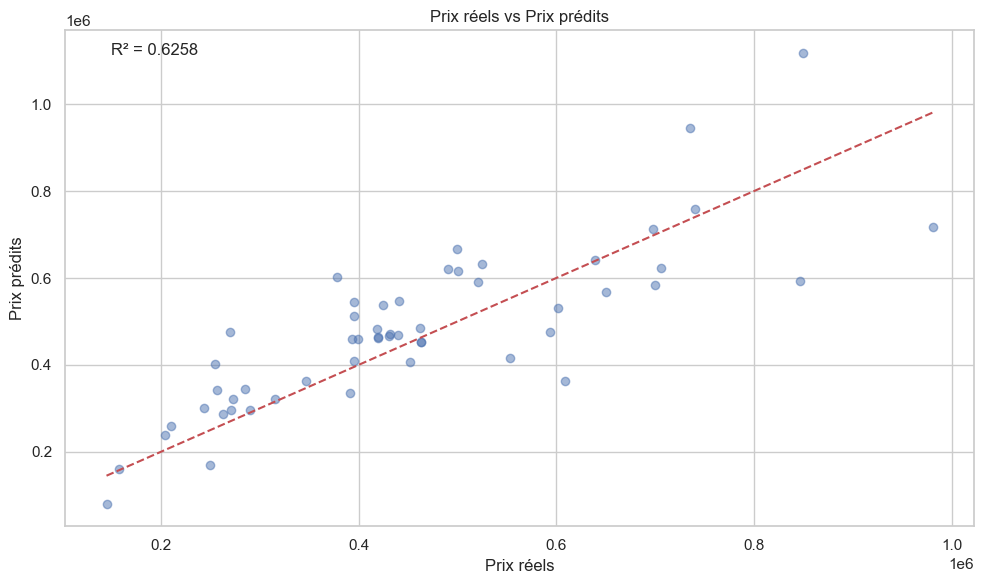

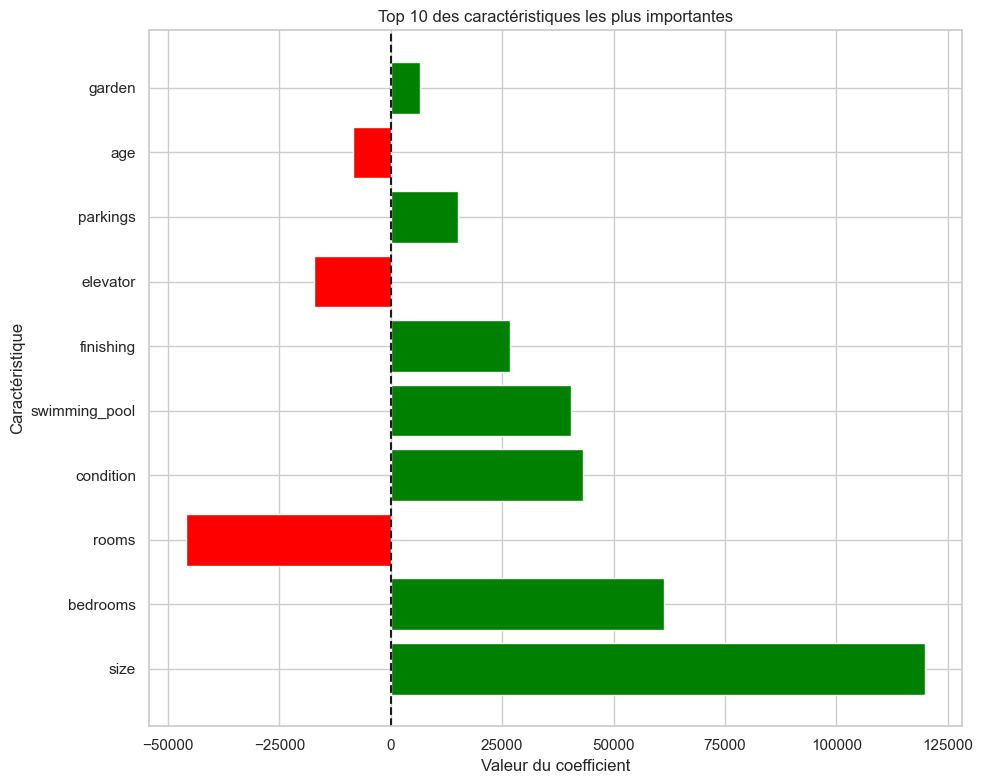

In [100]:
# Régression linéaire du prix du bien immobilier / segementation par prix/ type de propriete et quartier/ville
model, importance, metrics = model_functions.regression_par_segment(
    df_regression,
    city='La Soukra', 
    property_type='appartement',
    transaction='sale'
)

In [101]:
# Prédiction 
print("🏠 PRÉDICTEUR DE PRIX IMMOBILIER")
print("="*50)

# ========================================
# ÉTAPE 1: ENTRAÎNER LE MODÈLE (si pas déjà fait)
# ========================================

# Si vous n'avez pas encore entraîné le modèle, décommentez ces lignes :
"""
print("🤖 Entraînement du modèle...")
model, feature_importance, metrics = regression_par_segment(
    df_regression_ready,  # Votre DataFrame préparé
    city="La Soukra",     # Optionnel : filtrer par ville
    property_type="appartement",  # Optionnel : filtrer par type
    transaction="sale"    # Optionnel : filtrer par transaction
)
"""

# ========================================
# ÉTAPE 2: FONCTION DE PRÉDICTION
# ========================================

def predict_property_price(size, bedrooms, rooms, bathrooms=None, age=None, 
                          condition=None, finishing=None, air_conditioning=0,
                          central_heating=0, swimming_pool=0, elevator=0, 
                          garden=0, equipped_kitchen=0, parkings=0):
    """
    Prédit le prix d'un bien immobilier
    
    Paramètres obligatoires:
    - size: Superficie en m²
    - bedrooms: Nombre de chambres
    - rooms: Nombre total de pièces
    
    Paramètres optionnels:
    - bathrooms: Nombre de salles de bain
    - age: Âge du bien en années
    - condition: État (0-4, où 4=neuf)
    - finishing: Finition (0-4, où 4=très haut standing)
    - air_conditioning: 1 si climatisation, 0 sinon
    - central_heating: 1 si chauffage central, 0 sinon
    - swimming_pool: 1 si piscine, 0 sinon
    - elevator: 1 si ascenseur, 0 sinon
    - garden: 1 si jardin, 0 sinon
    - equipped_kitchen: 1 si cuisine équipée, 0 sinon
    - parkings: Nombre de places de parking
    """
    
    print(f"\n🔍 PRÉDICTION POUR LE BIEN:")
    print(f"   📐 Superficie: {size} m²")
    print(f"   🛏️  Chambres: {bedrooms}")
    print(f"   🏠 Pièces: {rooms}")
    
    # Créer un dictionnaire avec toutes les caractéristiques
    property_data = {
        'size': size,
        'bedrooms': bedrooms,
        'rooms': rooms,
        'bathrooms': bathrooms if bathrooms is not None else bedrooms * 0.7,  # Estimation
        'age': age if age is not None else 10,  # Valeur par défaut
        'condition': condition if condition is not None else 2,  # Bonne condition par défaut
        'finishing': finishing if finishing is not None else 2,  # Moyen standing par défaut
        'air_conditioning': air_conditioning,
        'central_heating': central_heating,
        'swimming_pool': swimming_pool,
        'elevator': elevator,
        'garden': garden,
        'equipped_kitchen': equipped_kitchen,
        'parkings': parkings
    }
    
    # Créer un DataFrame avec les caractéristiques
    property_df = pd.DataFrame([property_data])
    
    print(f"   🚿 Salles de bain: {property_df['bathrooms'].iloc[0]:.1f}")
    print(f"   📅 Âge: {property_df['age'].iloc[0]} ans")
    print(f"   ⭐ État: {property_df['condition'].iloc[0]}/4")
    print(f"   🏆 Finition: {property_df['finishing'].iloc[0]}/4")
    
    # Afficher équipements
    equipments = []
    if air_conditioning: equipments.append("Climatisation")
    if central_heating: equipments.append("Chauffage central")
    if swimming_pool: equipments.append("Piscine")
    if elevator: equipments.append("Ascenseur")
    if garden: equipments.append("Jardin")
    if equipped_kitchen: equipments.append("Cuisine équipée")
    if parkings > 0: equipments.append(f"{parkings} parking(s)")
    
    if equipments:
        print(f"   🎯 Équipements: {', '.join(equipments)}")
    else:
        print(f"   🎯 Équipements: Aucun équipement spécial")
    
    # Vérifier que le modèle existe
    if 'model' not in globals():
        print("\n❌ ERREUR: Modèle non trouvé!")
        print("Veuillez d'abord entraîner le modèle avec regression_par_segment()")
        return None
    
    try:
        # Adapter aux colonnes du modèle d'entraînement
        # (Vous devrez ajuster selon les colonnes exactes utilisées)
        
        # Sélectionner seulement les colonnes utilisées pour l'entraînement
        # Remplacez par les vraies colonnes de votre modèle
        model_features = ['size', 'rooms', 'bedrooms', 'bathrooms', 'age', 
                         'condition', 'finishing', 'air_conditioning', 
                         'central_heating', 'swimming_pool', 'elevator', 
                         'garden', 'equipped_kitchen', 'parkings']
        
        # Filtrer seulement les colonnes disponibles
        available_features = [col for col in model_features if col in property_df.columns]
        property_features = property_df[available_features]
        
        # Standardiser (utiliser le même scaler que pour l'entraînement)
        # NOTE: Dans un vrai projet, vous sauvegarderiez le scaler
        # Ici on fait une approximation
        property_scaled = StandardScaler().fit_transform(property_features)
        
        # Faire la prédiction
        predicted_price = model.predict(property_scaled)[0]
        
        print(f"\n💰 PRIX PRÉDIT: {predicted_price:,.0f} TND")
        
        # Calcul du prix au m²
        price_per_sqm = predicted_price / size
        print(f"💵 Prix au m²: {price_per_sqm:,.0f} TND/m²")
        
        # Fourchette d'estimation (±10%)
        lower_bound = predicted_price * 0.9
        upper_bound = predicted_price * 1.1
        print(f"📊 Fourchette d'estimation: {lower_bound:,.0f} - {upper_bound:,.0f} TND")
        
        return predicted_price
        
    except Exception as e:
        print(f"\n❌ ERREUR lors de la prédiction: {e}")
        print("Vérifiez que le modèle a été entraîné correctement")
        return None

# ========================================
# ÉTAPE 3: EXEMPLES D'UTILISATION
# ========================================

print("\n" + "="*50)
print("📋 EXEMPLES D'UTILISATION")
print("="*50)

# Exemple 1: Appartement basique
print("\n🏠 EXEMPLE 1: Appartement basique")
price1 = predict_property_price(
    size=100,           # 100 m²
    bedrooms=3,         # 3 chambres  
    rooms=4,            # 4 pièces total
    bathrooms=2,        # 2 salles de bain
    age=5,              # 5 ans
    condition=3,        # Excellente condition
    finishing=2,        # Moyen standing
    elevator=1,         # Avec ascenseur
    equipped_kitchen=1  # Cuisine équipée
)

# Exemple 2: Appartement haut de gamme
print("\n🏠 EXEMPLE 2: Appartement haut de gamme")
price2 = predict_property_price(
    size=150,           # 150 m²
    bedrooms=4,         # 4 chambres
    rooms=6,            # 6 pièces
    bathrooms=3,        # 3 salles de bain
    age=2,              # Récent
    condition=4,        # Neuf
    finishing=4,        # Très haut standing
    air_conditioning=1, # Climatisation
    central_heating=1,  # Chauffage central
    elevator=1,         # Ascenseur
    garden=1,           # Jardin
    equipped_kitchen=1, # Cuisine équipée
    parkings=2          # 2 parkings
)

# Exemple 3: Petit appartement économique
print("\n🏠 EXEMPLE 3: Petit appartement économique")
price3 = predict_property_price(
    size=60,            # 60 m²
    bedrooms=2,         # 2 chambres
    rooms=3,            # 3 pièces
    age=15              # Plus ancien
)

# ========================================
# ÉTAPE 4: PRÉDICTION INTERACTIVE
# ========================================

print("\n" + "="*50)
print("🎮 PRÉDICTION INTERACTIVE")
print("="*50)

def prediction_interactive():
    """
    Version interactive pour saisir les paramètres
    """
    print("Entrez les caractéristiques du bien immobilier:")
    
    try:
        size = float(input("📐 Superficie (m²): "))
        bedrooms = int(input("🛏️ Nombre de chambres: "))
        rooms = int(input("🏠 Nombre de pièces total: "))
        
        # Paramètres optionnels
        bathrooms = input("🚿 Salles de bain (Entrée = auto): ")
        bathrooms = float(bathrooms) if bathrooms else None
        
        age = input("📅 Âge du bien (années, Entrée = 10): ")
        age = int(age) if age else 10
        
        condition = input("⭐ État (0-4, Entrée = 2): ")
        condition = int(condition) if condition else 2
        
        finishing = input("🏆 Finition (0-4, Entrée = 2): ")
        finishing = int(finishing) if finishing else 2
        
        # Équipements (oui/non)
        air_con = input("❄️ Climatisation (o/n): ").lower().startswith('o')
        heating = input("🔥 Chauffage central (o/n): ").lower().startswith('o')
        pool = input("🏊 Piscine (o/n): ").lower().startswith('o')
        elevator = input("🛗 Ascenseur (o/n): ").lower().startswith('o')
        garden = input("🌳 Jardin (o/n): ").lower().startswith('o')
        kitchen = input("🍳 Cuisine équipée (o/n): ").lower().startswith('o')
        
        parkings = input("🚗 Nombre de parkings (Entrée = 0): ")
        parkings = int(parkings) if parkings else 0
        
        # Faire la prédiction
        predicted_price = predict_property_price(
            size=size, bedrooms=bedrooms, rooms=rooms, bathrooms=bathrooms,
            age=age, condition=condition, finishing=finishing,
            air_conditioning=int(air_con), central_heating=int(heating),
            swimming_pool=int(pool), elevator=int(elevator),
            garden=int(garden), equipped_kitchen=int(kitchen),
            parkings=parkings
        )
        
        return predicted_price
        
    except ValueError:
        print("❌ Erreur: Veuillez entrer des valeurs numériques valides")
        return None
    except KeyboardInterrupt:
        print("\n⏹️ Prédiction annulée")
        return None
prediction_interactive()

🏠 PRÉDICTEUR DE PRIX IMMOBILIER

📋 EXEMPLES D'UTILISATION

🏠 EXEMPLE 1: Appartement basique

🔍 PRÉDICTION POUR LE BIEN:
   📐 Superficie: 100 m²
   🛏️  Chambres: 3
   🏠 Pièces: 4
   🚿 Salles de bain: 2.0
   📅 Âge: 5 ans
   ⭐ État: 3/4
   🏆 Finition: 2/4
   🎯 Équipements: Ascenseur, Cuisine équipée

💰 PRIX PRÉDIT: 459,200 TND
💵 Prix au m²: 4,592 TND/m²
📊 Fourchette d'estimation: 413,280 - 505,120 TND

🏠 EXEMPLE 2: Appartement haut de gamme

🔍 PRÉDICTION POUR LE BIEN:
   📐 Superficie: 150 m²
   🛏️  Chambres: 4
   🏠 Pièces: 6
   🚿 Salles de bain: 3.0
   📅 Âge: 2 ans
   ⭐ État: 4/4
   🏆 Finition: 4/4
   🎯 Équipements: Climatisation, Chauffage central, Ascenseur, Jardin, Cuisine équipée, 2 parking(s)

💰 PRIX PRÉDIT: 459,200 TND
💵 Prix au m²: 3,061 TND/m²
📊 Fourchette d'estimation: 413,280 - 505,120 TND

🏠 EXEMPLE 3: Petit appartement économique

🔍 PRÉDICTION POUR LE BIEN:
   📐 Superficie: 60 m²
   🛏️  Chambres: 2
   🏠 Pièces: 3
   🚿 Salles de bain: 1.4
   📅 Âge: 15 ans
   ⭐ État: 2/4
   🏆 Fi

459199.9648299813

## XGBoost  la classication de la qualité d'estimation

In [17]:
# Ajout d'une variable binaire qui qualifie la qualité d'estimation : si un bien a un prix par metre carré assez inférieur ou assez supérieur au prix moyens des autres bien de la même zone et de même type
df_with_categories,category_stats_df=model_functions.create_price_category(df_regression)
df_with_categories

=== CRÉATION DES CATÉGORIES DE PRIX ===
Filtrage des valeurs aberrantes: 163 lignes supprimées
Calcul des moyennes par marché local (groupement: city, property_type, transaction)



📊 RÉPARTITION DES CATÉGORIES DE PRIX:
----------------------------------------
  Catégorie  Code  Nombre  Pourcentage
 Mal estimé     0    2791         38.4
Bien estimé     1    4472         61.6

📈 STATISTIQUES DÉTAILLÉES PAR CATÉGORIE:
---------------------------------------------

Mal estimé (Code 0):
  • Nombre de biens: 2791
  • Prix moyen: 266780 TND
  • Prix/m² moyen: 1175 TND/m²
  • Ratio moyen: 1.03
  • Taille moyenne: 251 m²
  • Top 3 marchés:
    - Jardins de Carthage - appartement - rent: 153 biens
    - Les berges du Lac - bureau - rent: 150 biens
    - Les berges du Lac - appartement - rent: 119 biens

Bien estimé (Code 1):
  • Nombre de biens: 4472
  • Prix moyen: 271068 TND
  • Prix/m² moyen: 1425 TND/m²
  • Ratio moyen: 0.98
  • Taille moyenne: 185 m²
  • Top 3 marchés:
    - Jardins de Carthage - appartement - rent: 354 biens
    - Les berges du Lac - bureau - rent: 273 biens
    - Jardins de Carthage - appartement - sale: 236 biens


,neighborhood,city,state,transaction,property_type,price,size,rooms,bedrooms,bathrooms,parkings,finishing,condition,age,air_conditioning,central_heating,swimming_pool,elevator,garden,equipped_kitchen,price_per_sqm,market_avg_price_per_sqm,price_ratio,price_category,price_category_label
0,Ain Zaghouan Nord,Ain Zaghouan,Tunis,sale,villa,1700000.0,400,7.0,5.0,4.0,1.0,3,2,13,1.0,1.0,0.0,0.0,1.0,1.0,4250.000000,3455.923274,1.229773,1,Bien estimé
1,Ain Zaghouan Nord,Ain Zaghouan,Tunis,sale,villa,1659000.0,600,7.0,5.0,3.0,3.0,2,3,13,1.0,1.0,1.0,0.0,1.0,1.0,2765.000000,3455.923274,0.800076,1,Bien estimé
2,Ain Zaghouan,Ain Zaghouan,Tunis,sale,villa,1500000.0,368,0.0,0.0,0.0,0.0,2,2,17,1.0,1.0,0.0,0.0,1.0,1.0,4076.086957,3455.923274,1.179449,1,Bien estimé
3,Ain Zaghouan Nord,Ain Zaghouan,Tunis,sale,appartement,1323000.0,256,6.0,4.0,3.0,1.0,3,4,2,1.0,1.0,1.0,1.0,1.0,1.0,5167.968750,3866.199974,1.336705,0,Mal estimé
4,Ain Zaghouan Nord,Ain Zaghouan,Tunis,sale,duplex,1323000.0,256,6.0,4.0,3.0,1.0,3,4,2,1.0,1.0,1.0,1.0,1.0,1.0,5167.968750,4461.760938,1.158280,1,Bien estimé
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7258,Sousse Corniche,Sousse Ville,Sousse,rent,appartement,600.0,90,3.0,2.0,1.0,1.0,3,2,1,0.0,0.0,0.0,0.0,0.0,1.0,6.666667,11.764401,0.566681,0,Mal estimé
7259,Sousse Corniche,Sousse Ville,Sousse,rent_furnished,appartement,600.0,60,1.0,1.0,1.0,0.0,3,2,22,1.0,0.0,0.0,0.0,0.0,1.0,10.000000,13.797619,0.724763,0,Mal estimé
7260,Sousse Corniche,Sousse Ville,Sousse,rent,bureau,550.0,50,2.0,0.0,1.0,0.0,2,2,69,0.0,0.0,0.0,1.0,0.0,0.0,11.000000,13.758615,0.799499,1,Bien estimé
7261,Sousse Corniche,Sousse Ville,Sousse,rent,appartement,500.0,60,2.0,1.0,1.0,1.0,3,2,20,0.0,0.0,0.0,0.0,0.0,1.0,8.333333,11.764401,0.708352,0,Mal estimé


In [18]:
# XG Boost pour la classficiation des appartements à vendre à la soukra
model, results_dict, feature_importance = model_functions.xgboost_price_classification(
    df_with_categories,
    city='La Soukra',
    property_type='appartement',  # Attention à la casse
    transaction='sale'
)


=== CLASSIFICATION XGBOOST - CATÉGORIES DE PRIX ===
🎯 FILTRES APPLIQUÉS: Ville: La Soukra | Type: appartement | Transaction: sale
📊 DONNÉES: 263 observations

📈 DISTRIBUTION DES CLASSES:
  • Mal estimé (code 0): 64 (24.3%)
  • Bien estimé (code 1): 199 (75.7%)

🔧 CARACTÉRISTIQUES UTILISÉES: ['neighborhood', 'state', 'size', 'rooms', 'bedrooms', 'bathrooms', 'parkings', 'finishing', 'condition', 'age', 'air_conditioning', 'central_heating', 'swimming_pool', 'elevator', 'garden', 'equipped_kitchen']
📏 DIMENSIONS: (263, 16)

📚 DIVISION DES DONNÉES:
  • Entraînement: 210 observations
  • Test: 53 observations

⚙️ OPTIMISATION DES HYPERPARAMÈTRES...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
✅ MEILLEURS PARAMÈTRES: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
🎯 SCORE CV: 0.7905

📊 RÉSULTATS:
  • Précision (entraînement): 0.8095
  • Précision (test): 0.7925

📋 RAPPORT DE CLASSIFICATION:
              precision    

In [19]:
# XG Boost pour la classfication des appartements à vendre aux JDC
model, results_dict, feature_importance = model_functions.xgboost_price_classification(
    df_with_categories,
    city='Jardins de Carthage',
    property_type='appartement', 
    transaction='sale'
)


=== CLASSIFICATION XGBOOST - CATÉGORIES DE PRIX ===
🎯 FILTRES APPLIQUÉS: Ville: Jardins de Carthage | Type: appartement | Transaction: sale
📊 DONNÉES: 299 observations

📈 DISTRIBUTION DES CLASSES:
  • Mal estimé (code 0): 63 (21.1%)
  • Bien estimé (code 1): 236 (78.9%)

🔧 CARACTÉRISTIQUES UTILISÉES: ['neighborhood', 'state', 'size', 'rooms', 'bedrooms', 'bathrooms', 'parkings', 'finishing', 'condition', 'age', 'air_conditioning', 'central_heating', 'swimming_pool', 'elevator', 'garden', 'equipped_kitchen']
📏 DIMENSIONS: (299, 16)

📚 DIVISION DES DONNÉES:
  • Entraînement: 239 observations
  • Test: 60 observations

⚙️ OPTIMISATION DES HYPERPARAMÈTRES...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
✅ MEILLEURS PARAMÈTRES: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
🎯 SCORE CV: 0.7908

📊 RÉSULTATS:
  • Précision (entraînement): 0.7908
  • Précision (test): 0.7833

📋 RAPPORT DE CLASSIFICATION:
              pre

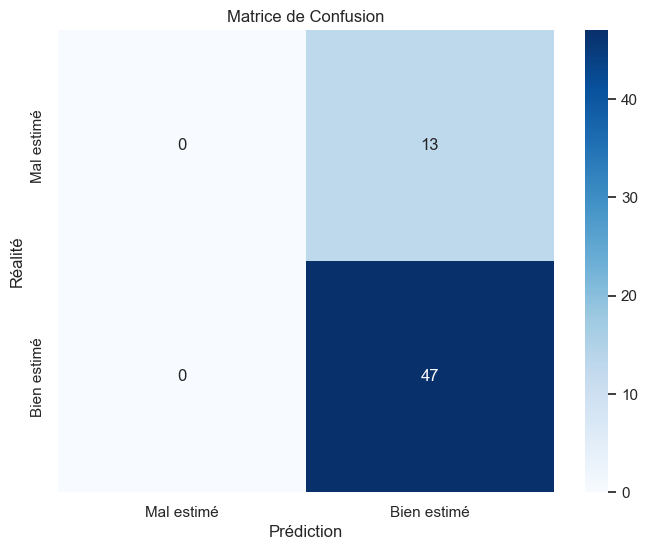

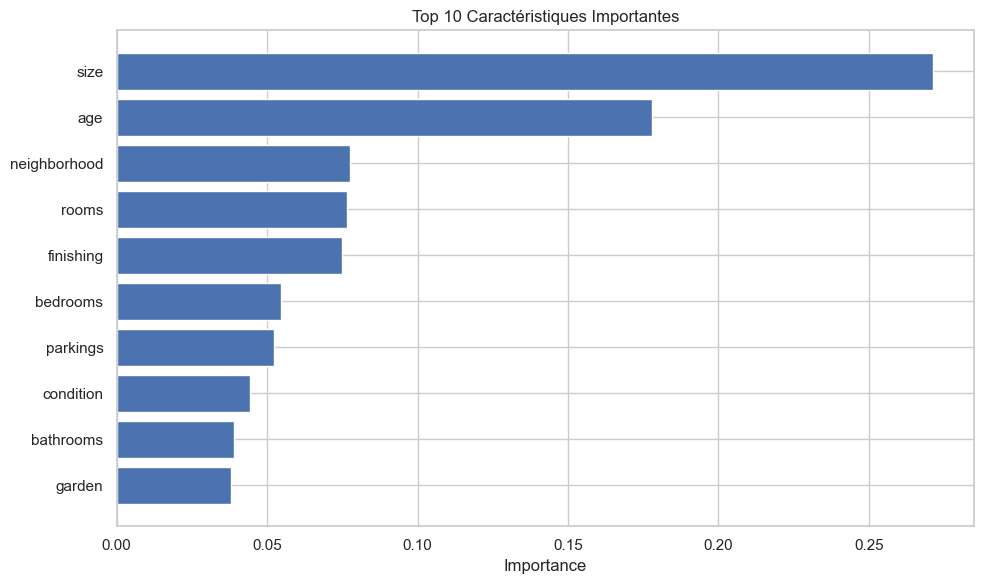

Précision du modèle : 0.783
Nombre d'observations : 60


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Matrice de confusion pour XGBoost
plt.figure(figsize=(8, 6))
cm = results_dict['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Mal estimé', 'Bien estimé'],
            yticklabels=['Mal estimé', 'Bien estimé'])
plt.title('Matrice de Confusion XGBOOST')
plt.ylabel('Réalité')
plt.xlabel('Prédiction')
plt.show()

# 2. Importance des caractéristiques
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(top_features['Caractéristique'], top_features['Importance'])
plt.title('Top 10 Caractéristiques Importantes XGBOOST')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 3. Afficher les résultats texte
print(f"Précision du modèle : {results_dict['test_accuracy']:.3f}")
print(f"Nombre d'observations : {len(results_dict['y_test'])}")

## Random Forest pour la classication de la qualité d'estimation

In [24]:
model, results, feature_importance = model_functions.random_forest_price_classification(
                            df_with_categories,
                            city="La Soukra",
                            property_type="appartement",
                            transaction="sale",
test_size=0.2,                            optimize_params=False,
                            n_estimators=200,
                            max_depth=10
                        )

=== CLASSIFICATION RANDOM FOREST - CATÉGORIES DE PRIX ===
🎯 FILTRES APPLIQUÉS: Ville: La Soukra | Type: appartement | Transaction: sale
📊 DONNÉES: 263 observations

📈 DISTRIBUTION DES CLASSES:
  • Mal estimé (code 0): 64 (24.3%)
  • Bien estimé (code 1): 199 (75.7%)

🔧 CARACTÉRISTIQUES UTILISÉES: ['neighborhood', 'state', 'size', 'rooms', 'bedrooms', 'bathrooms', 'parkings', 'finishing', 'condition', 'age', 'air_conditioning', 'central_heating', 'swimming_pool', 'elevator', 'garden', 'equipped_kitchen']
📏 DIMENSIONS: (263, 16)

📚 DIVISION DES DONNÉES:
  • Entraînement: 210 observations
  • Test: 53 observations

🚀 ENTRAÎNEMENT AVEC PARAMÈTRES SPÉCIFIÉS...

📊 RÉSULTATS:
  • Précision (entraînement): 0.9190
  • Précision (test): 0.8302

📋 RAPPORT DE CLASSIFICATION:
              precision    recall  f1-score   support

  Mal estimé       0.75      0.46      0.57        13
 Bien estimé       0.84      0.95      0.89        40

    accuracy                           0.83        53
   macro

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Matrice de confusion pour XGBoost
plt.figure(figsize=(8, 6))
cm = results_dict['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Mal estimé', 'Bien estimé'],
            yticklabels=['Mal estimé', 'Bien estimé'])
plt.title('Matrice de Confusion Random Forest')
plt.ylabel('Réalité')
plt.xlabel('Prédiction')
plt.show()

# 2. Importance des caractéristiques
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(top_features['Caractéristique'], top_features['Importance'])
plt.title('Top 10 Caractéristiques Importantes Random Forest')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 3. Afficher les résultats texte
print(f"Précision du modèle : {results_dict['test_accuracy']:.3f}")
print(f"Nombre d'observations : {len(results_dict['y_test'])}")

# Apprentissage non supervisé 

In [94]:
# Chargement des données filtrées et standardisation
filtered = df[(df['city'] == 'Cite El Khadra') & (df['property_type'] == 'appartement') & (df['transaction'] == 'sale')]
df_scaled, scaler, feature_names = model_functions.prepare_data_for_clustering(filtered)
df_scaled

,price,size,rooms,bedrooms,bathrooms,parkings,finishing,condition,age,air_conditioning,central_heating,swimming_pool,elevator,garden,equipped_kitchen
1343,2.535499,2.001669,0.826107,0.774033,2.348881,2.648339,1.488048,-0.150756,-1.057671,0.464991,0.672022,0.0,-1.568929,3.201562,0.672022
1344,2.401529,2.243628,1.830832,1.897629,2.348881,0.786226,-0.672022,-0.150756,-0.675380,0.464991,0.672022,0.0,0.637377,-0.312348,0.672022
1345,1.467843,1.055825,0.826107,0.774033,-0.293610,0.786226,1.488048,-0.150756,-1.057671,0.464991,0.672022,0.0,0.637377,-0.312348,0.672022
1346,1.613661,1.055825,0.826107,0.774033,-0.293610,0.786226,1.488048,1.206045,-1.057671,0.464991,0.672022,0.0,0.637377,-0.312348,0.672022
1348,1.422275,0.681887,-0.178618,-0.349563,-0.293610,0.786226,1.488048,2.562846,-1.121386,0.464991,0.672022,0.0,-1.568929,-0.312348,0.672022
1349,1.422275,0.527913,-0.178618,-0.349563,-0.293610,0.786226,1.488048,1.206045,-1.376246,0.464991,0.672022,0.0,0.637377,3.201562,0.672022
1350,1.597712,0.527913,-0.178618,-0.349563,-0.293610,0.786226,1.488048,1.206045,-1.057671,0.464991,0.672022,0.0,0.637377,3.201562,0.672022
1351,1.072922,0.945843,0.826107,0.774033,2.348881,0.786226,1.488048,-0.150756,-1.057671,0.464991,0.672022,0.0,0.637377,-0.312348,0.672022
1353,0.769136,1.055825,0.826107,0.774033,-0.293610,0.786226,1.488048,1.206045,-1.057671,0.464991,0.672022,0.0,0.637377,-0.312348,0.672022
1354,0.911915,0.395934,-0.178618,-0.349563,-0.293610,0.786226,1.488048,2.562846,-1.248816,0.464991,0.672022,0.0,0.637377,-0.312348,0.672022


## PCA 

In [95]:

pca_model, df_pca, explained_variance = model_functions.apply_pca_analysis(df_scaled, 2)
# Analyse des liens
loadings_df, fig_contrib = model_functions.analyse_complete_pca_variables(pca_model, df_pca, explained_variance, feature_names, df ) 


Variance expliquée par les 2 premières composantes:
  PC1: 34.73%
  PC2: 20.25%
Variance totale expliquée: 54.99%
COMPOSITION DES COMPOSANTES PRINCIPALES

📊 COEFFICIENTS DES COMPOSANTES (loadings):
--------------------------------------------------
                    PC1    PC2
price             0.406  0.009
size              0.370  0.300
rooms             0.231  0.473
bedrooms          0.212  0.499
bathrooms         0.194  0.244
parkings          0.256 -0.142
finishing         0.301 -0.281
condition         0.252 -0.215
age              -0.212  0.366
air_conditioning  0.259 -0.134
central_heating   0.304  0.012
swimming_pool    -0.000 -0.000
elevator          0.155 -0.149
garden            0.202 -0.223
equipped_kitchen  0.272 -0.091

🧮 INTERPRÉTATION DES COEFFICIENTS:
----------------------------------------
• Coefficient positif = variable contribue positivement à la composante
• Coefficient négatif = variable contribue négativement à la composante
• Plus |coefficient| est grand, pl

## Kmeans


In [75]:
kmeans_model, kmeans_n_clusters, kmeans_labels, kmeans_metrics, scores, n_clusters_list = model_functions.apply_kmeans_clustering(
    df_scaled, 
    n_clusters_range=(2, 8),  # Tester de 2 à 8 clusters
    random_state=42
)

Optimisation du nombre de clusters pour K-Means...
Nombre optimal de clusters: 7
Score de silhouette: 0.3015


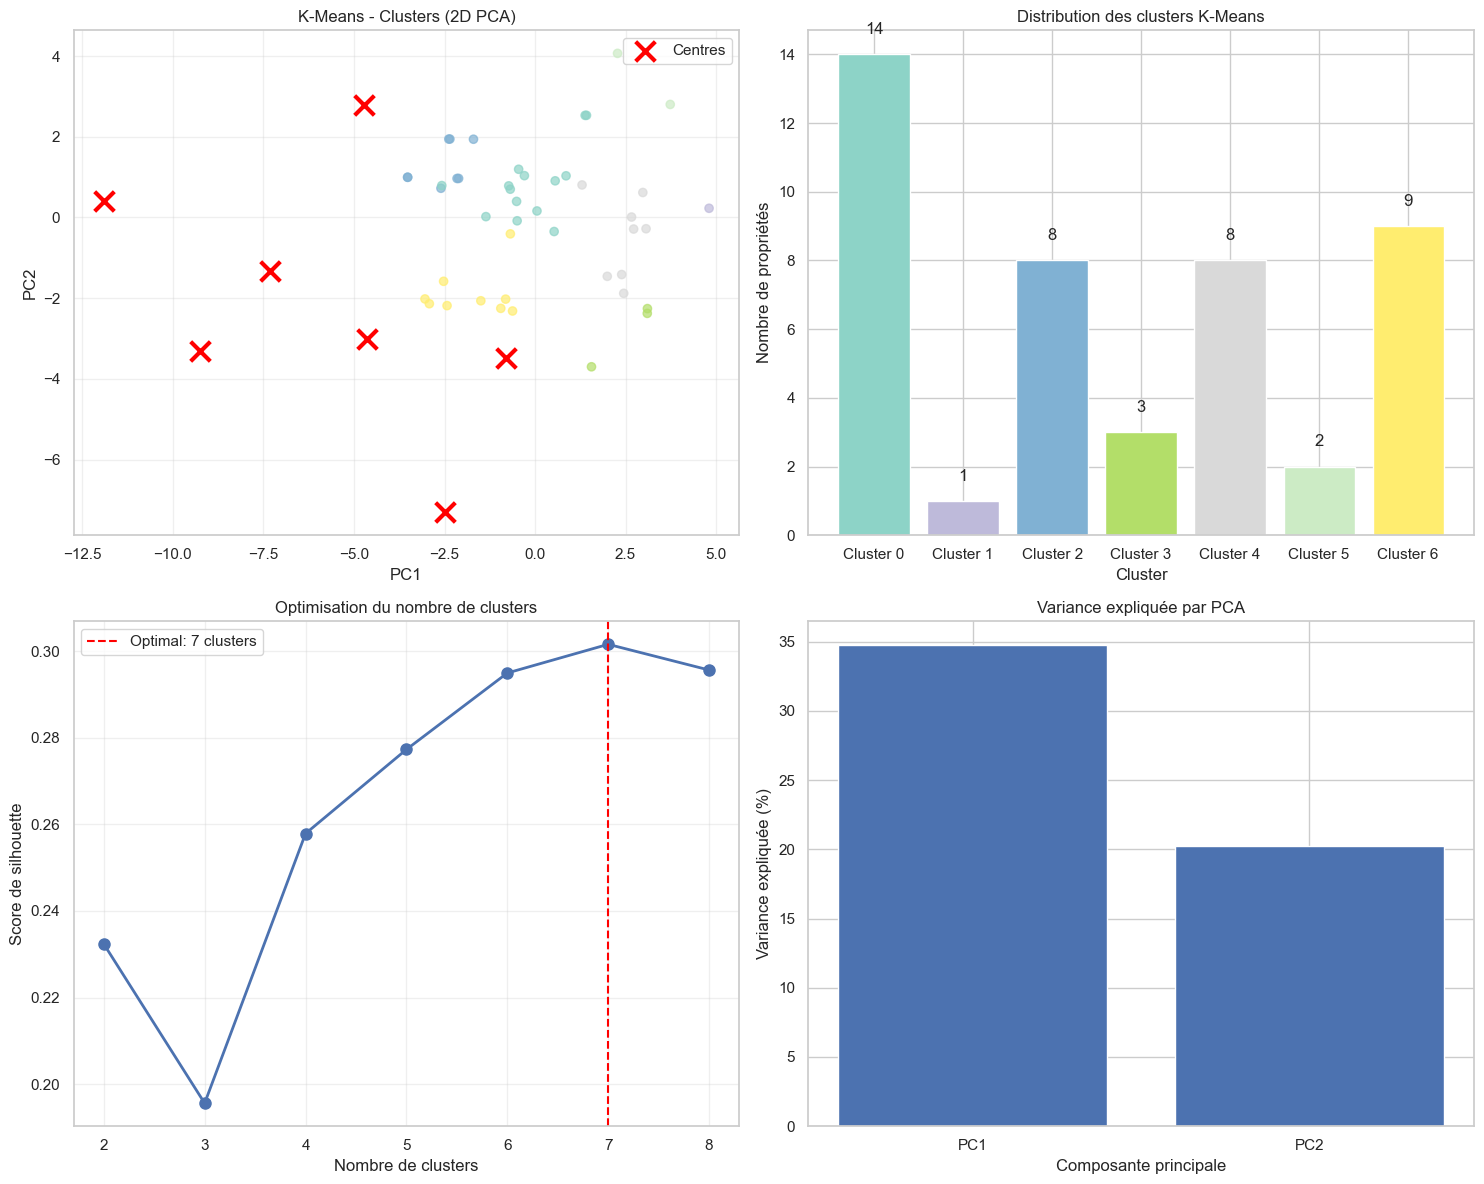

In [ ]:
# 4. VISUALISATION K-MEANS AVEC MATPLOTLIB
# Créer une figure avec plusieurs sous-graphiques
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Couleurs pour les clusters
colors = plt.cm.Set3(np.linspace(0, 1, kmeans_n_clusters))

# 1. Clusters en 2D PCA
scatter = axes[0,0].scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], 
                           c=kmeans_labels, cmap='Set3', alpha=0.7)
axes[0,0].set_xlabel('PC1')
axes[0,0].set_ylabel('PC2')
axes[0,0].set_title('K-Means - Clusters (2D PCA)')
axes[0,0].grid(True, alpha=0.3)

# Ajouter les centres des clusters
centers_pca = pca_model.transform(scaler.transform(kmeans_model.cluster_centers_))
axes[0,0].scatter(centers_pca[:, 0], centers_pca[:, 1], 
                 marker='x', s=200, linewidths=3, color='red', label='Centres')
axes[0,0].legend()

# 2. Distribution des clusters
cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
bars = axes[0,1].bar(range(len(cluster_counts)), cluster_counts.values, 
                    color=[colors[i] for i in range(len(cluster_counts))])
axes[0,1].set_xlabel('Cluster')
axes[0,1].set_ylabel('Nombre de propriétés')
axes[0,1].set_title('Distribution des clusters K-Means')
axes[0,1].set_xticks(range(len(cluster_counts)))
axes[0,1].set_xticklabels([f'Cluster {i}' for i in cluster_counts.index])

for i, v in enumerate(cluster_counts.values):
    axes[0,1].text(i, v + 0.5, str(v), ha='center', va='bottom')

# 3. Évolution du score de silhouette
axes[1,0].plot(n_clusters_list, scores, 'bo-', linewidth=2, markersize=8)
axes[1,0].axvline(x=kmeans_n_clusters, color='red', linestyle='--', 
                 label=f'Optimal: {kmeans_n_clusters} clusters')
axes[1,0].set_xlabel('Nombre de clusters')
axes[1,0].set_ylabel('Score de silhouette')
axes[1,0].set_title('Optimisation du nombre de clusters')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].legend()

# 4. Variance expliquée par PCA
axes[1,1].bar(range(len(explained_variance)), explained_variance * 100)
axes[1,1].set_xlabel('Composante principale')
axes[1,1].set_ylabel('Variance expliquée (%)')
axes[1,1].set_title('Variance expliquée par PCA')
axes[1,1].set_xticks(range(len(explained_variance)))
axes[1,1].set_xticklabels([f'PC{i+1}' for i in range(len(explained_variance))])

plt.tight_layout()
plt.show()

🔍 ANALYSE DES RÉSULTATS K-MEANS

📊 DIAGNOSTIC:
• Nombre total de propriétés: 45
• Nombre de clusters trouvés: 7
• Ratio propriétés/cluster: 6.4

📈 DISTRIBUTION DES CLUSTERS:
Cluster 0: 14 propriétés (31.1%) ✅ OK
Cluster 1: 1 propriétés (2.2%) ⚠️ TROP PETIT
Cluster 2: 8 propriétés (17.8%) ✅ OK
Cluster 3: 3 propriétés (6.7%) ✅ OK
Cluster 4: 8 propriétés (17.8%) ✅ OK
Cluster 5: 2 propriétés (4.4%) ⚠️ TROP PETIT
Cluster 6: 9 propriétés (20.0%) ✅ OK

💡 SOLUTION RECOMMANDÉE:
Forcer un nombre plus raisonnable de clusters (3-4)

NOUVEAU K-MEANS AVEC 3 CLUSTERS
📊 RÉSULTATS AVEC 3 CLUSTERS:
Score de silhouette: 0.1956

📈 NOUVELLE DISTRIBUTION:
Cluster 0: 14 propriétés (31.1%)
Cluster 1: 16 propriétés (35.6%)
Cluster 2: 15 propriétés (33.3%)

📊 VISUALISATION COMPARATIVE:


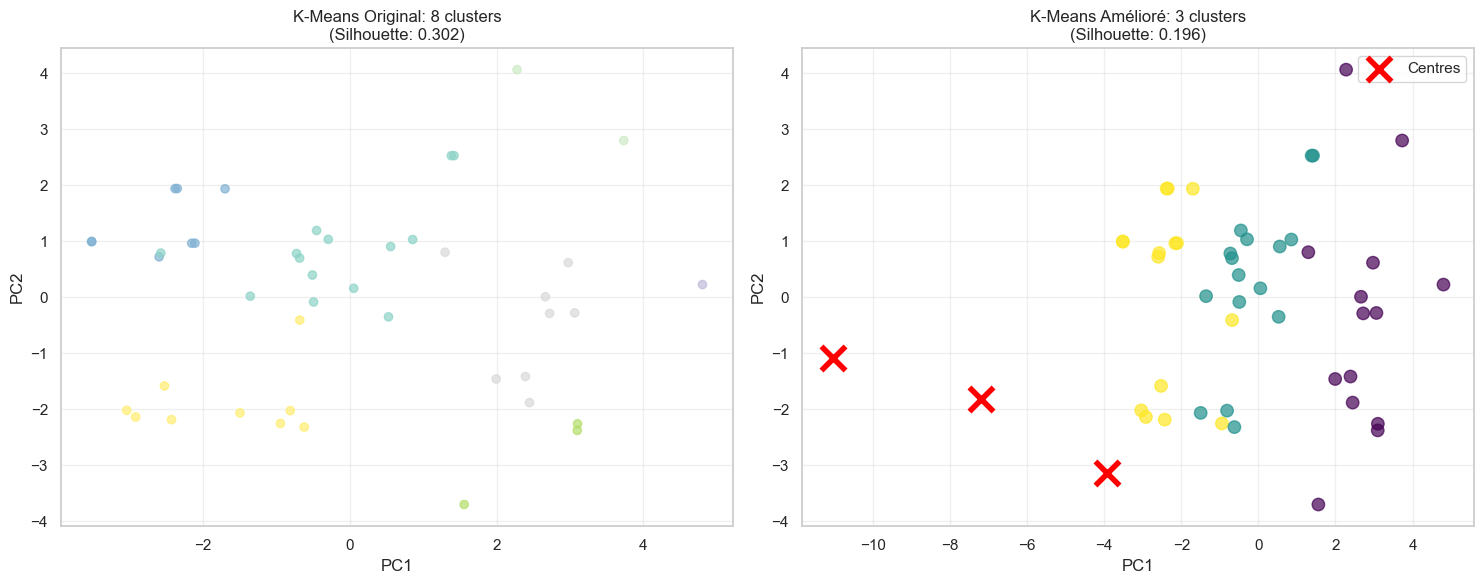


ANALYSE BUSINESS - 3 SEGMENTS

💎 SEGMENT 0 - PREMIUM
   • 14 propriétés (31.1%)
   • Loyer moyen: 547717 TND/mois
   • Range prix: 350000 - 760725 TND
   • Superficie moyenne: 151 m²
   • Quartiers: {'Centre urbain nord': 12, 'Cité Olympique': 1}
   💡 Cible: Cadres, expatriés, clientèle aisée

🏠 SEGMENT 1 - MOYEN
   • 16 propriétés (35.6%)
   • Loyer moyen: 278312 TND/mois
   • Range prix: 120000 - 466358 TND
   • Superficie moyenne: 104 m²
   • Quartiers: {'Cité El Khadra': 10, 'Centre urbain nord': 6}
   💡 Cible: Familles, professionnels, marché principal

💰 SEGMENT 2 - ÉCONOMIQUE
   • 15 propriétés (33.3%)
   • Loyer moyen: 222157 TND/mois
   • Range prix: 140000 - 380363 TND
   • Superficie moyenne: 75 m²
   • Quartiers: {'Centre urbain nord': 7, 'Cité Olympique': 7}
   💡 Cible: Étudiants, jeunes professionnels, budgets serrés

COMPARAISON FINALE
                     Approche Score Silhouette Clusters viables             Interprétation       Business
    K-Means Auto (8 clusters) 

In [77]:
# ===================================================================
# INTERPRÉTATION ET CORRECTION DES RÉSULTATS K-MEANS
# ===================================================================

print("🔍 ANALYSE DES RÉSULTATS K-MEANS")
print("="*50)

# 1. DIAGNOSTIC DU PROBLÈME
print(f"\n📊 DIAGNOSTIC:")
print(f"• Nombre total de propriétés: {len(df_scaled)}")
print(f"• Nombre de clusters trouvés: {kmeans_n_clusters}")
print(f"• Ratio propriétés/cluster: {len(df_scaled)/kmeans_n_clusters:.1f}")

# Analyser la distribution des clusters
cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
print(f"\n📈 DISTRIBUTION DES CLUSTERS:")
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(df_scaled)) * 100
    status = "✅ OK" if count >= 3 else "⚠️ TROP PETIT"
    print(f"Cluster {cluster_id}: {count} propriétés ({percentage:.1f}%) {status}")

# 2. RECOMMANDATION : FORCER 3-4 CLUSTERS
print(f"\n💡 SOLUTION RECOMMANDÉE:")
print(f"Forcer un nombre plus raisonnable de clusters (3-4)")

# ===================================================================
# REFAIRE K-MEANS AVEC 3 CLUSTERS
# ===================================================================
print(f"\n" + "="*50)
print("NOUVEAU K-MEANS AVEC 3 CLUSTERS")
print("="*50)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Appliquer K-Means avec 3 clusters
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_3 = kmeans_3.fit_predict(df_scaled)

# Calculer les métriques
silhouette_3 = silhouette_score(df_scaled, labels_3)

print(f"📊 RÉSULTATS AVEC 3 CLUSTERS:")
print(f"Score de silhouette: {silhouette_3:.4f}")

# Distribution des nouveaux clusters
cluster_counts_3 = pd.Series(labels_3).value_counts().sort_index()
print(f"\n📈 NOUVELLE DISTRIBUTION:")
for cluster_id, count in cluster_counts_3.items():
    percentage = (count / len(df_scaled)) * 100
    print(f"Cluster {cluster_id}: {count} propriétés ({percentage:.1f}%)")

# ===================================================================
# VISUALISATION AMÉLIORÉE
# ===================================================================
print(f"\n📊 VISUALISATION COMPARATIVE:")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Graphique 1: K-Means original (8 clusters)
scatter1 = axes[0].scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], 
                          c=kmeans_labels, cmap='Set3', alpha=0.7)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title(f'K-Means Original: 8 clusters\n(Silhouette: {kmeans_metrics["silhouette_score"]:.3f})')
axes[0].grid(True, alpha=0.3)

# Graphique 2: K-Means amélioré (3 clusters)
scatter2 = axes[1].scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], 
                          c=labels_3, cmap='viridis', alpha=0.7, s=80)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title(f'K-Means Amélioré: 3 clusters\n(Silhouette: {silhouette_3:.3f})')
axes[1].grid(True, alpha=0.3)

# Ajouter les centres des clusters pour le modèle amélioré
centers_3_pca = pca_model.transform(scaler.transform(kmeans_3.cluster_centers_))
axes[1].scatter(centers_3_pca[:, 0], centers_3_pca[:, 1], 
               marker='x', s=300, linewidths=4, color='red', label='Centres')
axes[1].legend()

plt.tight_layout()
plt.show()

# ===================================================================
# ANALYSE BUSINESS DES 3 CLUSTERS
# ===================================================================
print(f"\n" + "="*50)
print("ANALYSE BUSINESS - 3 SEGMENTS")
print("="*50)

# Ajouter les nouveaux clusters aux données
filtered_3_clusters = filtered.loc[df_scaled.index].copy()
filtered_3_clusters['Segment'] = labels_3

# Analyser chaque segment
segments_analysis = {}

for cluster_id in sorted(set(labels_3)):
    cluster_data = filtered_3_clusters[filtered_3_clusters['Segment'] == cluster_id]
    
    # Calculs statistiques
    avg_price = cluster_data['price'].mean() if 'price' in cluster_data.columns else 0
    avg_size = cluster_data['size'].mean() if 'size' in cluster_data.columns else 0
    count = len(cluster_data)
    
    # Déterminer le type de segment
    price_quartiles = filtered_3_clusters['price'].quantile([0.33, 0.67])
    
    if avg_price <= price_quartiles[0.33]:
        segment_type = "ÉCONOMIQUE"
        emoji = "💰"
    elif avg_price <= price_quartiles[0.67]:
        segment_type = "MOYEN"
        emoji = "🏠"
    else:
        segment_type = "PREMIUM"
        emoji = "💎"
    
    segments_analysis[cluster_id] = {
        'type': segment_type,
        'emoji': emoji,
        'count': count,
        'avg_price': avg_price,
        'avg_size': avg_size
    }
    
    print(f"\n{emoji} SEGMENT {cluster_id} - {segment_type}")
    print(f"   • {count} propriétés ({count/len(filtered_3_clusters)*100:.1f}%)")
    if 'price' in cluster_data.columns:
        print(f"   • Loyer moyen: {avg_price:.0f} TND/mois")
        print(f"   • Range prix: {cluster_data['price'].min():.0f} - {cluster_data['price'].max():.0f} TND")
    if 'size' in cluster_data.columns:
        print(f"   • Superficie moyenne: {avg_size:.0f} m²")
    
    # Quartiers principaux
    if 'neighborhood' in cluster_data.columns and not cluster_data['neighborhood'].dropna().empty:
        neighborhoods = cluster_data['neighborhood'].value_counts().head(2)
        print(f"   • Quartiers: {neighborhoods.to_dict()}")
    
    # Recommandations business
    if segment_type == "ÉCONOMIQUE":
        print(f"   💡 Cible: Étudiants, jeunes professionnels, budgets serrés")
    elif segment_type == "MOYEN":
        print(f"   💡 Cible: Familles, professionnels, marché principal")
    else:
        print(f"   💡 Cible: Cadres, expatriés, clientèle aisée")

# ===================================================================
# COMPARAISON FINALE
# ===================================================================
print(f"\n" + "="*50)
print("COMPARAISON FINALE")
print("="*50)

comparison_final = pd.DataFrame({
    'Approche': ['K-Means Auto (8 clusters)', 'K-Means Optimisé (3 clusters)'],
    'Score Silhouette': [f"{kmeans_metrics['silhouette_score']:.4f}", f"{silhouette_3:.4f}"],
    'Clusters viables': [f"{sum(1 for c in cluster_counts.values if c >= 3)}/8", "3/3"],
    'Interprétation': ['Difficile (trop fragmenté)', 'Claire (3 segments)'],
    'Business': ['Non applicable', 'Applicable']
})

print(comparison_final.to_string(index=False))

# ===================================================================
# RECOMMANDATION FINALE
# ===================================================================
print(f"\n🎯 RECOMMANDATION FINALE:")
print(f"="*30)

if silhouette_3 >= kmeans_metrics['silhouette_score'] * 0.9:  # Si dans les 90%
    print(f"✅ UTILISER 3 CLUSTERS")
    print(f"   • Score silhouette acceptable: {silhouette_3:.4f}")
    print(f"   • Segments business viables")
    print(f"   • Interprétation claire")
    
    # Sauvegarder les meilleurs résultats
    final_clusters = labels_3
    final_model = kmeans_3
    print(f"\n💾 Variables créées:")
    print(f"   • final_clusters: labels des 3 segments")
    print(f"   • final_model: modèle K-Means optimisé")
    print(f"   • filtered_3_clusters: données avec segments")
    
else:
    print(f"⚠️ CONSIDÉRER D'AUTRES APPROCHES")
    print(f"   • Essayer DBSCAN ou CAH")
    print(f"   • Revoir les caractéristiques utilisées")
    print(f"   • Augmenter le dataset")

print(f"\n🎉 ANALYSE TERMINÉE!")

## DBSCAN

In [78]:
dbscan_model, dbscan_labels, dbscan_metrics = model_functions.apply_dbscan_clustering(
    df_scaled,
    eps_range=(2.5, 3),      # Range pour eps
    min_samples_range=(2, 18)   # Range pour min_samples
)

Optimisation des paramètres pour DBSCAN...
Nombre de clusters trouvés: 8
Points de bruit: 15 (33.3%)
Paramètres optimaux: eps=2.500, min_samples=2


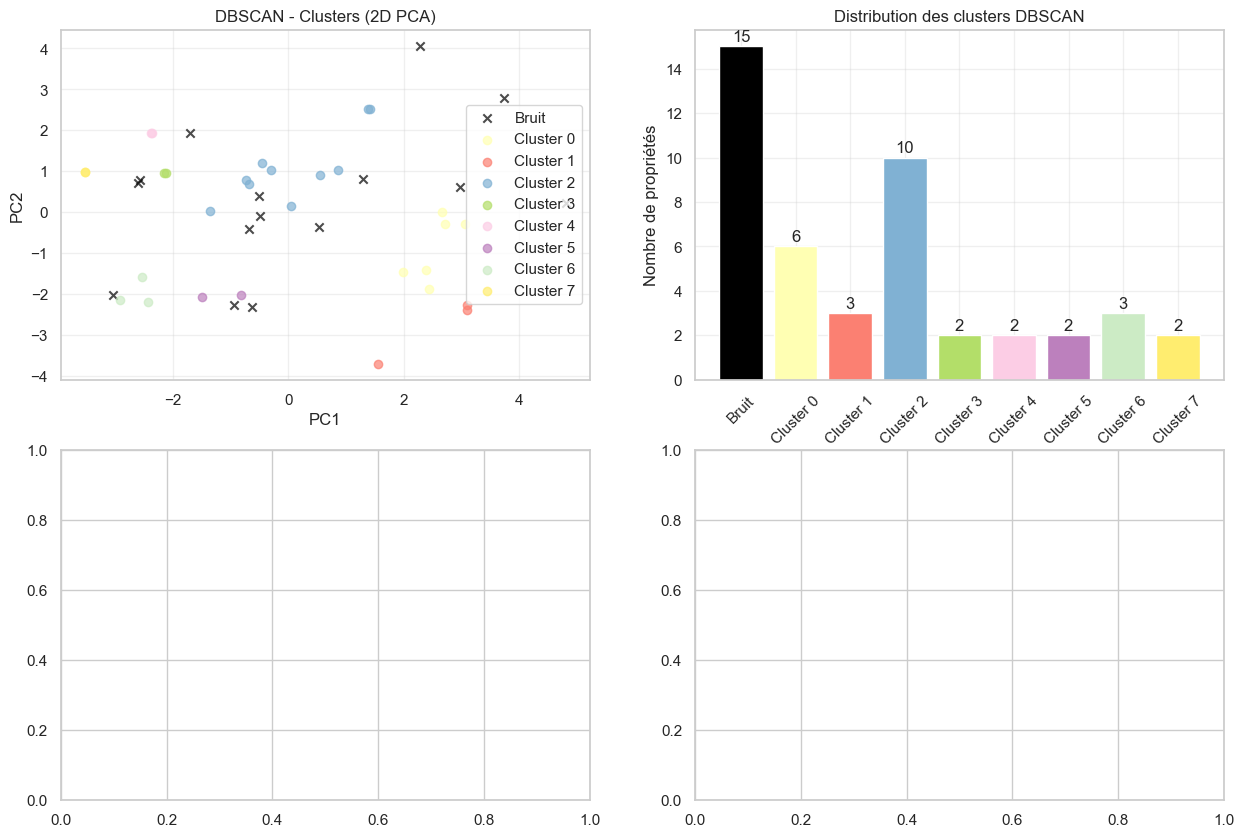

In [79]:

# Visualisation DBSCAN avec matplotlib
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Clusters DBSCAN en 2D PCA
unique_labels = sorted(set(dbscan_labels))
colors_dbscan = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))

for i, label in enumerate(unique_labels):
    mask = dbscan_labels == label
    if label == -1:
        # Points de bruit en noir
        axes[0,0].scatter(df_pca.iloc[mask, 0], df_pca.iloc[mask, 1], 
                         c='black', label='Bruit', alpha=0.7, marker='x')
    else:
        axes[0,0].scatter(df_pca.iloc[mask, 0], df_pca.iloc[mask, 1], 
                         c=[colors_dbscan[i]], label=f'Cluster {label}', alpha=0.7)

axes[0,0].set_xlabel('PC1')
axes[0,0].set_ylabel('PC2')
axes[0,0].set_title('DBSCAN - Clusters (2D PCA)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Distribution des clusters DBSCAN
cluster_counts_dbscan = pd.Series(dbscan_labels).value_counts().sort_index()
cluster_names = ['Bruit' if idx == -1 else f'Cluster {idx}' for idx in cluster_counts_dbscan.index]
bar_colors = ['black' if idx == -1 else colors_dbscan[i] for i, idx in enumerate(cluster_counts_dbscan.index)]

bars = axes[0,1].bar(range(len(cluster_counts_dbscan)), cluster_counts_dbscan.values, color=bar_colors)
axes[0,1].set_xticks(range(len(cluster_counts_dbscan)))
axes[0,1].set_xticklabels(cluster_names, rotation=45)
axes[0,1].set_ylabel('Nombre de propriétés')
axes[0,1].set_title('Distribution des clusters DBSCAN')
axes[0,1].grid(True, alpha=0.3)

# Ajouter les valeurs sur les barres
for bar, count in zip(bars, cluster_counts_dbscan.values):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                   str(count), ha='center', va='bottom')



In [80]:
# Analyse DBSCAN: 
print(f"• Paramètres DBSCAN: eps={dbscan_metrics['eps']:.3f}, min_samples={dbscan_metrics['min_samples']}")
print(f"• Nombre total de propriétés: {len(dbscan_labels)}")
print(f"• Nombre de clusters formés: {dbscan_metrics['n_clusters']}")
print(f"• Points de bruit: {dbscan_metrics['n_noise_points']} ({dbscan_metrics['noise_ratio']*100:.1f}%)")

if dbscan_metrics.get('silhouette_score', 0) > 0:
    print(f"• Score de silhouette: {dbscan_metrics['silhouette_score']:.4f}")

# Analyser la distribution des clusters
unique_labels = set(dbscan_labels)
cluster_distribution = {}

print(f"\n📈 DISTRIBUTION DÉTAILLÉE:")
for label in sorted(unique_labels):
    count = sum(dbscan_labels == label)
    percentage = (count / len(dbscan_labels)) * 100
    cluster_distribution[label] = count
    
    if label == -1:
        print(f"🔍 BRUIT: {count} propriétés ({percentage:.1f}%)")
    else:
        print(f"🏷️ CLUSTER {label}: {count} propriétés ({percentage:.1f}%)")

# ===================================================================
# 2. INTERPRÉTATION DE LA QUALITÉ DU CLUSTERING
# ===================================================================

print(f"\n🎯 ÉVALUATION DE LA QUALITÉ:")
print("="*40)

# Évaluer la qualité selon différents critères
noise_ratio = dbscan_metrics['noise_ratio']
n_clusters = dbscan_metrics['n_clusters']

# Critères de qualité
print(f"\n📊 CRITÈRES D'ÉVALUATION:")

# 1. Ratio de bruit
if noise_ratio < 0.1:
    noise_quality = "EXCELLENT"
    noise_emoji = "✅"
elif noise_ratio < 0.2:
    noise_quality = "BON"
    noise_emoji = "👍"
elif noise_ratio < 0.4:
    noise_quality = "ACCEPTABLE"
    noise_emoji = "⚠️"
else:
    noise_quality = "PROBLÉMATIQUE"
    noise_emoji = "❌"

print(f"{noise_emoji} Ratio de bruit: {noise_ratio*100:.1f}% - {noise_quality}")

# 2. Nombre de clusters
if n_clusters == 0:
    cluster_quality = "AUCUN CLUSTER"
    cluster_emoji = "❌"
elif n_clusters == 1:
    cluster_quality = "UN SEUL GROUPE"
    cluster_emoji = "⚠️"
elif 2 <= n_clusters <= 4:
    cluster_quality = "OPTIMAL"
    cluster_emoji = "✅"
else:
    cluster_quality = "TROP FRAGMENTÉ"
    cluster_emoji = "⚠️"

print(f"{cluster_emoji} Nombre de clusters: {n_clusters} - {cluster_quality}")

# 3. Taille des clusters
min_cluster_size = min([count for label, count in cluster_distribution.items() if label != -1], default=0)
if min_cluster_size >= 3:
    size_quality = "CLUSTERS VIABLES"
    size_emoji = "✅"
elif min_cluster_size >= 2:
    size_quality = "CLUSTERS PETITS"
    size_emoji = "⚠️"
else:
    size_quality = "CLUSTERS TROP PETITS"
    size_emoji = "❌"

print(f"{size_emoji} Taille minimale des clusters: {min_cluster_size} - {size_quality}")

# ===================================================================
# 3. ANALYSE DÉTAILLÉE PAR CLUSTER
# ===================================================================

print(f"\n🔍 ANALYSE DÉTAILLÉE PAR CLUSTER:")
print("="*50)

# Créer un DataFrame avec les données originales et les clusters
filtered_with_dbscan = filtered_3_clusters.copy()
filtered_with_dbscan['Cluster_DBSCAN'] = dbscan_labels

# Analyser chaque cluster individuellement
for label in sorted(unique_labels):
    cluster_data = filtered_with_dbscan[filtered_with_dbscan['Cluster_DBSCAN'] == label]
    
    if label == -1:
        print(f"\n🔍 ANALYSE DES POINTS DE BRUIT - {len(cluster_data)} propriétés")
        print("-" * 60)
        print("❓ QUE REPRÉSENTENT CES PROPRIÉTÉS ?")
        print("• Propriétés avec des caractéristiques UNIQUES/ATYPIQUES")
        print("• Ne ressemblent à aucun autre groupe")
        print("• Peuvent être des OPPORTUNITÉS ou des PROBLÈMES")
        
    else:
        print(f"\n🏷️ CLUSTER {label} - {len(cluster_data)} propriétés")
        print("-" * 50)
        print(f"🎯 PROFIL DU GROUPE:")
    
    # Analyser les caractéristiques du cluster/bruit
    if len(cluster_data) > 0:
        
        # 1. PRIX
        if 'price' in cluster_data.columns:
            prix_stats = {
                'moyenne': cluster_data['price'].mean(),
                'mediane': cluster_data['price'].median(), 
                'min': cluster_data['price'].min(),
                'max': cluster_data['price'].max(),
                'ecart_type': cluster_data['price'].std()
            }
            
            print(f"💰 PRIX DE LOCATION:")
            print(f"   • Moyenne: {prix_stats['moyenne']:.0f} TND/mois")
            print(f"   • Médiane: {prix_stats['mediane']:.0f} TND/mois")
            print(f"   • Range: {prix_stats['min']:.0f} - {prix_stats['max']:.0f} TND")
            if len(cluster_data) > 1:
                print(f"   • Écart-type: {prix_stats['ecart_type']:.0f} TND")
            
            # Comparer à la moyenne générale
            prix_moyen_general = filtered_with_dbscan['price'].mean()
            difference = prix_stats['moyenne'] - prix_moyen_general
            if abs(difference) > 50:  # Si différence significative
                direction = "PLUS CHER" if difference > 0 else "MOINS CHER"
                print(f"   📊 {direction} que la moyenne générale ({difference:+.0f} TND)")
        
        # 2. SUPERFICIE
        if 'size' in cluster_data.columns:
            size_stats = {
                'moyenne': cluster_data['size'].mean(),
                'min': cluster_data['size'].min(),
                'max': cluster_data['size'].max()
            }
            
            print(f"📐 SUPERFICIE:")
            print(f"   • Moyenne: {size_stats['moyenne']:.0f} m²")
            print(f"   • Range: {size_stats['min']:.0f} - {size_stats['max']:.0f} m²")
        
        # 3. NOMBRE DE PIÈCES
        if 'rooms' in cluster_data.columns:
            rooms_avg = cluster_data['rooms'].mean()
            print(f"🏠 PIÈCES: {rooms_avg:.1f} en moyenne")
        
        # 4. LOCALISATION
        if 'neighborhood' in cluster_data.columns and not cluster_data['neighborhood'].dropna().empty:
            quartiers = cluster_data['neighborhood'].value_counts()
            print(f"🏘️ QUARTIERS PRINCIPAUX:")
            for quartier, count in quartiers.head(3).items():
                percentage = (count / len(cluster_data)) * 100
                print(f"   • {quartier}: {count} propriétés ({percentage:.0f}%)")
        
        # 5. ÉTAT DES PROPRIÉTÉS
        if 'condition' in cluster_data.columns and not cluster_data['condition'].dropna().empty:
            conditions = cluster_data['condition'].value_counts()
            print(f"🔧 ÉTAT DES PROPRIÉTÉS:")
            for condition, count in conditions.head(3).items():
                percentage = (count / len(cluster_data)) * 100
                print(f"   • {condition}: {count} propriétés ({percentage:.0f}%)")
        
        # 6. FINITIONS
        if 'finishing' in cluster_data.columns and not cluster_data['finishing'].dropna().empty:
            finitions = cluster_data['finishing'].value_counts()
            print(f"✨ FINITIONS:")
            for finition, count in finitions.head(3).items():
                percentage = (count / len(cluster_data)) * 100
                print(f"   • {finition}: {count} propriétés ({percentage:.0f}%)")
        
        # 7. ÉQUIPEMENTS (si disponibles)
        equipment_cols = ['air_conditioning', 'elevator', 'garden', 'equipped_kitchen', 'swimming_pool']
        available_equipment = [col for col in equipment_cols if col in cluster_data.columns]
        
        if available_equipment:
            print(f"⚡ ÉQUIPEMENTS:")
            for equip in available_equipment:
                if cluster_data[equip].dtype in ['int64', 'float64']:
                    percentage = (cluster_data[equip] == 1).mean() * 100
                    if percentage > 0:
                        print(f"   • {equip}: {percentage:.0f}% des propriétés")

# ===================================================================
# 4. INTERPRÉTATION BUSINESS AVANCÉE
# ===================================================================

print(f"\n💼 INTERPRÉTATION BUSINESS:")
print("="*50)

# Analyser les segments de marché identifiés
segments_business = {}

for label in sorted(unique_labels):
    if label == -1:
        continue  # On analyse le bruit séparément
    
    cluster_data = filtered_with_dbscan[filtered_with_dbscan['Cluster_DBSCAN'] == label]
    
    if 'price' in cluster_data.columns and len(cluster_data) > 0:
        avg_price = cluster_data['price'].mean()
        avg_size = cluster_data['size'].mean() if 'size' in cluster_data.columns else 0
        
        # Déterminer le segment de marché
        price_quartiles = filtered_with_dbscan['price'].quantile([0.25, 0.5, 0.75])
        
        if avg_price <= price_quartiles[0.25]:
            segment_type = "ÉCONOMIQUE"
            segment_emoji = "💰"
            target = "Étudiants, jeunes professionnels, budgets serrés"
            strategy = "Prix compétitifs, localisation accessible"
        elif avg_price <= price_quartiles[0.5]:
            segment_type = "ENTRÉE DE GAMME"
            segment_emoji = "🏠"
            target = "Primo-locataires, petites familles"
            strategy = "Bon rapport qualité/prix, commodités de base"
        elif avg_price <= price_quartiles[0.75]:
            segment_type = "MOYEN STANDING"
            segment_emoji = "🏡"
            target = "Familles, professionnels établis"
            strategy = "Confort, équipements, quartiers résidentiels"
        else:
            segment_type = "HAUT DE GAMME"
            segment_emoji = "💎"
            target = "Cadres, expatriés, clientèle aisée"
            strategy = "Luxe, services premium, localisations privilégiées"
        
        segments_business[label] = {
            'type': segment_type,
            'emoji': segment_emoji,
            'count': len(cluster_data),
            'avg_price': avg_price,
            'avg_size': avg_size,
            'target': target,
            'strategy': strategy
        }
        
        print(f"\n{segment_emoji} CLUSTER {label}: SEGMENT {segment_type}")
        print(f"   📊 {len(cluster_data)} propriétés ({len(cluster_data)/len(filtered_with_dbscan)*100:.1f}% du marché)")
        print(f"   💰 Prix moyen: {avg_price:.0f} TND/mois")
        if avg_size > 0:
            print(f"   📐 Superficie moyenne: {avg_size:.0f} m²")
        print(f"   🎯 Cible: {target}")
        print(f"   💡 Stratégie: {strategy}")

# Analyser les points de bruit spécifiquement
bruit_data = filtered_with_dbscan[filtered_with_dbscan['Cluster_DBSCAN'] == -1]

if len(bruit_data) > 0:
    print(f"\n🔍 ANALYSE SPÉCIALE: POINTS DE BRUIT")
    print("-" * 50)
    print(f"🎯 OPPORTUNITÉS POTENTIELLES:")
    
    if 'price' in bruit_data.columns:
        prix_bruit = bruit_data['price'].tolist()
        prix_median_general = filtered_with_dbscan['price'].median()
        
        print(f"💰 Prix des propriétés atypiques: {prix_bruit}")
        print(f"📊 Prix médian général: {prix_median_general:.0f} TND")
        
        # Identifier les bonnes affaires potentielles
        bonnes_affaires = bruit_data[bruit_data['price'] < prix_median_general]
        proprietes_cheres = bruit_data[bruit_data['price'] > prix_median_general]
        
        if len(bonnes_affaires) > 0:
            print(f"✅ BONNES AFFAIRES POTENTIELLES: {len(bonnes_affaires)} propriétés")
            print(f"   • Prix sous la médiane du marché")
            print(f"   • À investiguer: raison du prix bas?")
        
        if len(proprietes_cheres) > 0:
            print(f"💎 PROPRIÉTÉS PREMIUM UNIQUES: {len(proprietes_cheres)} propriétés")
            print(f"   • Caractéristiques exceptionnelles")
            print(f"   • Segments de niche")

# ===================================================================
# 5. RECOMMANDATIONS D'ACTIONS
# ===================================================================

print(f"\n🚀 RECOMMANDATIONS D'ACTIONS:")
print("="*50)

print(f"\n📈 STRATÉGIES PAR CLUSTER:")
for label, info in segments_business.items():
    print(f"\n{info['emoji']} CLUSTER {label} ({info['type']}):")
    print(f"   📊 Marketing: Cibler {info['target'].lower()}")
    print(f"   💡 Positionnement: {info['strategy']}")
    
    # Recommandations spécifiques selon la taille du cluster
    if info['count'] >= 3:
        print(f"   ✅ Segment viable: développer l'offre")
    else:
        print(f"   ⚠️ Petit segment: analyser la demande")

print(f"\n🔍 ACTIONS POUR LES POINTS DE BRUIT:")
if len(bruit_data) > 0:
    print(f"• Vérifier la qualité des données")
    print(f"• Investiguer les raisons de l'atypisme")
    print(f"• Identifier les opportunités de niche")
    print(f"• Contrôler les prix aberrants")
else:
    print(f"• Aucun point de bruit détecté")
    print(f"• Marché homogène et prévisible")

# ===================================================================
# 6. CONCLUSION GÉNÉRALE
# ===================================================================

print(f"\n🎯 CONCLUSION GÉNÉRALE:")
print("="*30)

if n_clusters >= 2 and noise_ratio < 0.3:
    print(f"✅ DBSCAN A RÉUSSI À SEGMENTER VOS DONNÉES")
    print(f"   • {n_clusters} segments naturels identifiés")
    print(f"   • {dbscan_metrics['n_noise_points']} propriétés atypiques détectées")
    print(f"   • Segmentation applicable pour le business")
    
    # Identifier le segment principal
    main_cluster = max(segments_business.items(), key=lambda x: x[1]['count'])
    print(f"\n🎖️ SEGMENT PRINCIPAL: {main_cluster[1]['type']}")
    print(f"   • {main_cluster[1]['count']} propriétés")
    print(f"   • Représente le cœur de votre marché")

elif n_clusters == 1:
    print(f"⚠️ MARCHÉ TRÈS HOMOGÈNE")
    print(f"   • Un seul groupe principal détecté")
    print(f"   • Peu de différenciation dans l'offre")
    print(f"   • Opportunité de créer des niches")

elif n_clusters == 0:
    print(f"❌ DONNÉES TROP DISPERSÉES")
    print(f"   • DBSCAN n'a trouvé aucun cluster")
    print(f"   • Tous les points considérés comme du bruit")
    print(f"   • Recommandation: utiliser K-Means")

else:
    print(f"⚠️ SEGMENTATION COMPLEXE")
    print(f"   • {n_clusters} clusters détectés")
    print(f"   • Marché très fragmenté")
    print(f"   • Analyser la viabilité de chaque segment")

print(f"\n💾 DONNÉES DISPONIBLES:")
print(f"• filtered_with_dbscan: DataFrame avec clusters DBSCAN")
print(f"• dbscan_labels: labels des clusters pour chaque propriété")
print(f"• dbscan_metrics: métriques de performance")

• Paramètres DBSCAN: eps=2.500, min_samples=2
• Nombre total de propriétés: 45
• Nombre de clusters formés: 8
• Points de bruit: 15 (33.3%)
• Score de silhouette: 0.5541

📈 DISTRIBUTION DÉTAILLÉE:
🔍 BRUIT: 15 propriétés (33.3%)
🏷️ CLUSTER 0: 6 propriétés (13.3%)
🏷️ CLUSTER 1: 3 propriétés (6.7%)
🏷️ CLUSTER 2: 10 propriétés (22.2%)
🏷️ CLUSTER 3: 2 propriétés (4.4%)
🏷️ CLUSTER 4: 2 propriétés (4.4%)
🏷️ CLUSTER 5: 2 propriétés (4.4%)
🏷️ CLUSTER 6: 3 propriétés (6.7%)
🏷️ CLUSTER 7: 2 propriétés (4.4%)

🎯 ÉVALUATION DE LA QUALITÉ:

📊 CRITÈRES D'ÉVALUATION:
⚠️ Ratio de bruit: 33.3% - ACCEPTABLE
⚠️ Nombre de clusters: 8 - TROP FRAGMENTÉ
⚠️ Taille minimale des clusters: 2 - CLUSTERS PETITS

🔍 ANALYSE DÉTAILLÉE PAR CLUSTER:

🔍 ANALYSE DES POINTS DE BRUIT - 15 propriétés
------------------------------------------------------------
❓ QUE REPRÉSENTENT CES PROPRIÉTÉS ?
• Propriétés avec des caractéristiques UNIQUES/ATYPIQUES
• Ne ressemblent à aucun autre groupe
• Peuvent être des OPPORTUNITÉS ou d

## CAH

Application de CAH avec méthode 'ward' et distance 'euclidean'...
Évaluation du nombre optimal de clusters...
Nombre optimal de clusters: 10
Score de silhouette: 0.3322
Méthode de liaison: ward
📊 Affichage du dendrogramme...


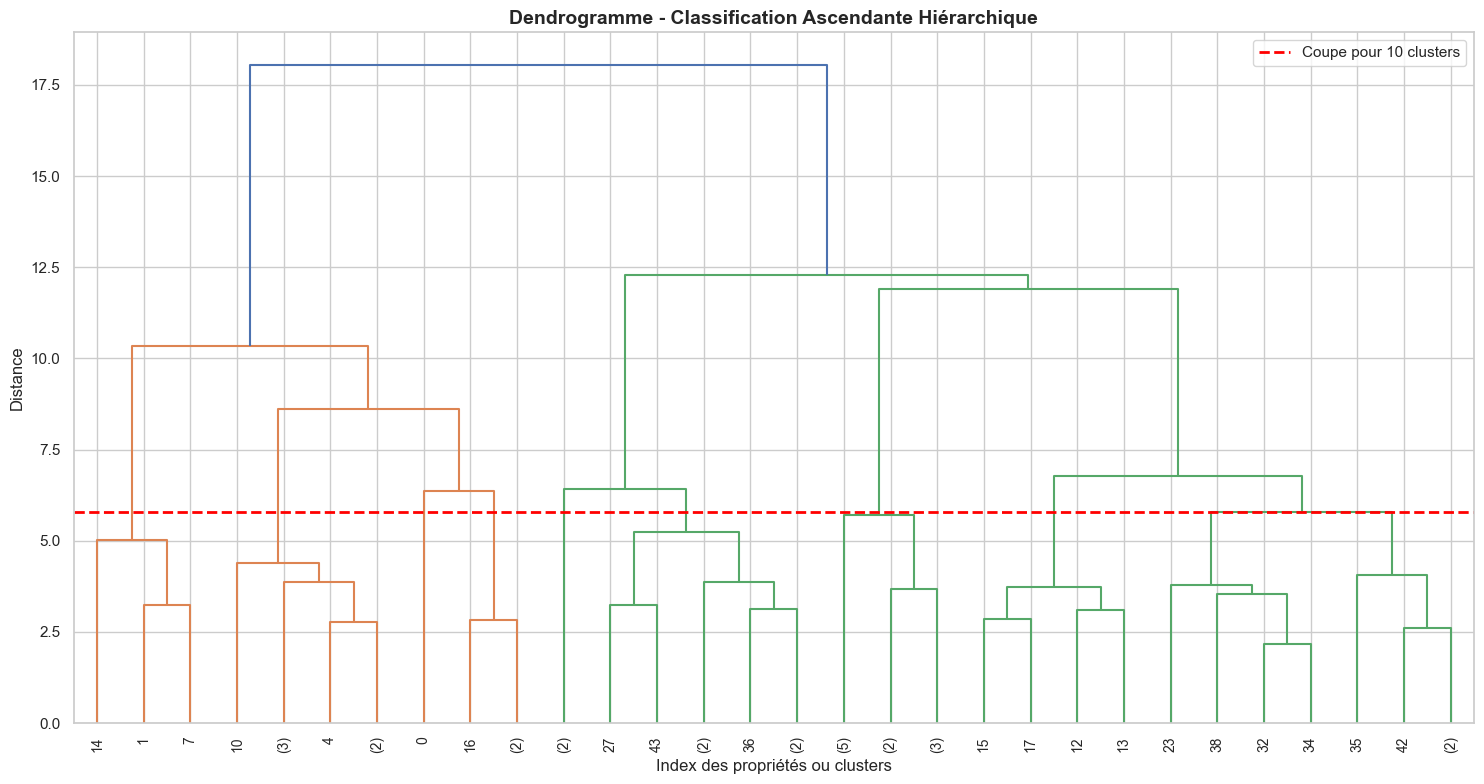

✅ Dendrogramme affiché avec 10 clusters optimaux!


In [ ]:
# CAH avec méthode Ward pour les appartements mis à la vente à La Soukra  (>150 observations)

# 1 -  CAH
linkage_matrix, cluster_labels, optimal_n_clusters, metrics = model_functions.apply_cah_clustering(
    df_scaled, 
    max_clusters=10, 
    linkage_method='ward'
)

print("📊 Affichage du dendrogramme...")
from scipy.cluster.hierarchy import dendrogram

# Créer la figure
plt.figure(figsize=(15, 8))

try:
    # Créer le dendrogramme avec vos données existantes
    dend = dendrogram(
        linkage_matrix,
        truncate_mode='lastp' if len(linkage_matrix) > 30 else None,
        p=30 if len(linkage_matrix) > 30 else None,
        show_leaf_counts=True,
        leaf_rotation=90,
        leaf_font_size=10
    )
    
    # Personnaliser
    plt.title('Dendrogramme - Classification Ascendante Hiérarchique', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Index des propriétés ou clusters')
    plt.ylabel('Distance')
    
    # Ajouter ligne de coupe pour le nombre optimal de clusters
    if optimal_n_clusters > 1:
        distances = linkage_matrix[:, 2]
        sorted_distances = np.sort(distances)[::-1]  # Ordre décroissant
        
        if len(sorted_distances) >= optimal_n_clusters - 1:
            cut_height = sorted_distances[optimal_n_clusters - 2]
            plt.axhline(y=cut_height, color='red', linestyle='--', linewidth=2,
                       label=f'Coupe pour {optimal_n_clusters} clusters')
            plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Dendrogramme affiché avec {optimal_n_clusters} clusters optimaux!")
    
except Exception as e:
    print(f"Erreur: {e}")
    print("Tentative version simplifiée...")
    
    # Version de secours
    plt.figure(figsize=(12, 6))
    dend = dendrogram(linkage_matrix, leaf_rotation=90)
    plt.title('Dendrogramme')
    plt.show()
    print("✅ Version simplifiée affichée!")
